In [ ]:
from mongoengine import connect
from pycoshark.mongomodels import People, Commit, Project, VCSSystem, PullRequestSystem, PullRequest
from pycoshark.utils import create_mongodb_uri_string

# Database credentials
user = ''
password = ''
host = ''
port = ''
authentication_db = ''
database = ""
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
connect(database, host=uri)

# Fetch project id and version control system id for the 'kafka' project
# The only() decides the data that is actually retrieved from the MongoDB. Always restrict this to the field that you require!
project = Project.objects(name='kafka').only('id').get()
vcs_system = VCSSystem.objects(project_id=project.id).only('id','url').get()
print('url of VCS system of the project: %s' % vcs_system.url)

# determine latest commit of the commons-math project
last_commit = None
max_date = None
# loop over all commits of kafka
for commit in Commit.objects(vcs_system_id=vcs_system.id).only('committer_date', 'committer_id','revision_hash').timeout(False):
    if max_date is None:
        last_commit = commit
        max_date = commit.committer_date
    if max_date<commit.committer_date:
        last_commit = commit
        max_date = commit.committer_date
        
print('revision hash of last commit in database: %s' % last_commit.revision_hash)
print('date of last commit in database: %s' % last_commit.committer_date)
print('link to commit on Github: https://github.com/apache/kafka/commit/%s' % last_commit.revision_hash)

# fetch committer from People
last_committer = People.objects(id=last_commit.committer_id).only('name','email').get()
print('last commit by %s (%s)' % (last_committer.name,last_committer.email))

In [ ]:
pull_request_system = PullRequestSystem.objects(project_id=project.id).only('id','url').get()
print('url of VCS system of the project: %s' % pull_request_system.url)
for pull_request in PullRequest.objects(pull_request_system_id=pull_request_system.id).only('created_at','creator_id','target_repo_url').timeout(False):
    if max_date is None:
        last_pull_request = pull_request
        max_date = pull_request.created_at
    if max_date < pull_request.created_at:
        last_pull_request = pull_request
        max_date = pull_request.created_at
print('date of last pull request in database: %s' % last_pull_request.created_at)
last_creator = People.objects(id=last_pull_request.creator_id).only('name','email').get()
print('last creator by %s (%s)' % (last_creator.name,last_creator.email))
        

In [ ]:

print('closed pull requests for this project:')
mylist = []
for pull_req in PullRequest.objects(pull_request_system_id=pull_request_system.id).only('author_association','creator_id','created_at','merged_at','updated_at','state','title','description').timeout(False):
    
    if pull_req.state =='closed':
       
        if pull_req.merged_at is None:
            pull_req.merged = '1' #not merged
            pull_end = pull_req.updated_at
        else:
            pull_req.merged = '2' #merged
            pull_end = pull_req.merged_at
        
        creator = People.objects(id=pull_req.creator_id).only('name','email','username').get()
        #print ([creator.username] , [pull_req.merged],pull_req.merged_at) dont print this for big project with more pr
        #my_list = creator.username, pull_req.merged , pull_req.merged_at
        my_list = [creator.username,   pull_req.merged, pull_req.author_association,  pull_req.created_at,  pull_end,  pull_req.title,  pull_req.description]
        mylist.append(my_list)
print(mylist)
print(len(mylist))

In [ ]:
import csv
header = ['author', 'status',  'level', 'CreatedDate',  'EndDate',  'title', 'description' ]
data = mylist
with open('pr_kafka.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)


In [ ]:
myself=[]
print('open pull requests for this project:')
for pull_req in PullRequest.objects(pull_request_system_id=pull_request_system.id).only('author_association','creator_id','created_at','merged_at','updated_at','state','title','description').timeout(False):
    
    
    if pull_req.state =='open':
        creator = People.objects(id=pull_req.creator_id).only('name','email','username').get()
        #print ([creator.username] , [pull_req.merged],pull_req.merged_at) dont print this for big project with more pr
        #my_list = creator.username, pull_req.merged , pull_req.merged_at
        my_self = [creator.username,  creator.name,  pull_req.author_association,  pull_req.created_at,  pull_req.title, pull_req.description]
        myself.append(my_self)

        myself.append(my_self)
print(myself)
print(len(myself))

In [ ]:
import csv
header = ['author', 'name', 'level',  'CreatedDate',  'title', 'description' ]
data = myself
with open('pr_kafka_predict.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)


In [17]:
#if you already have data excute from here
import csv
import pandas as pd
closed_df = pd.read_csv('pr_kafka.csv')
open_df = pd.read_csv('pr_kafka_predict.csv')

In [18]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import os
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
import nltk
import string
import numpy as np

In [19]:
def SRLUNH_CLEANER(lf):
    sln = list()
    lines = lf["input_data"].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        sln.append(words)
    return sln


In [20]:

closed_df['CreatedDate'] = pd.to_datetime(closed_df['CreatedDate'], errors='coerce')
closed_df['EndDate'] = pd.to_datetime(closed_df['EndDate'], errors='coerce')
closed_df['days'] = closed_df['EndDate'] - closed_df['CreatedDate']

In [21]:
closed_df.isna().sum()


author            0
status            0
level             0
CreatedDate       0
EndDate           0
title             0
description    1858
days              0
dtype: int64

In [22]:
closed_df.description = closed_df.description.fillna('zero')
closed_df.description.isna().sum()


0

In [23]:
#model 1 starts here
df1 = closed_df

In [24]:
df1['input_data'] = df1['author']+' '+ df1['description']+' '+df1['level']+' '+df1['title']#+' '+df1['level']+' '+df1['author']+' '+ df1['description']
closed_df.isna().sum()

author         0
status         0
level          0
CreatedDate    0
EndDate        0
title          0
description    0
days           0
input_data     0
dtype: int64

In [25]:
df1.input_data

0       chia7712 Instead of creating intermediate coll...
1       gwenshap If attempting to build the project fr...
2       asasvari Fix log message during shutdown\r\n\r...
3       wenbingshen Fixed a syntax error where the pre...
4       dengziming As the title CONTRIBUTOR MINOR: ren...
                              ...                        
9041    dibbhatt KAFKA-948\nWhen the broker which is t...
9042    MichaelBlume zero NONE Fix mis-spell in Consum...
9043    polymorphic Following https://issues.apache.or...
9044    fsaintjacques This issue can be caused by a no...
9045    azymnis Compiled and used fine. I had issues w...
Name: input_data, Length: 9046, dtype: object

In [26]:
df1.isna().sum()

author         0
status         0
level          0
CreatedDate    0
EndDate        0
title          0
description    0
days           0
input_data     0
dtype: int64

In [27]:
closed_text_cleaner1 = SRLUNH_CLEANER(df1) #cleans text
closed_text_cleaner1

['instead creating intermediate collections batch data directly check last topic autogenerated data collect partitions topic committer checklist excluded commit message verify design implementation verify test coverage ci build status verify documentation including upgrade notes contributor minor refactor fetchresponsetomessage avoid creating lot',
 'gwenshap attempting build project directory spaces name gradlewrapperjar missing script fail download new one condition break apphome resolve multiple strings protecting apphome quotes fixes issue tested deleting gradlewrapper trying build contributor minor gradle wrapper handle directories spaces',
 'asasvari fix log message shutdown detailed description change necessary pr title pr message become squashed commit message use separate comment ping reviewers summary testing strategy including rationale feature bug fix unit andor integration tests expected behaviour change system tests considered larger changes committer checklist excluded c

In [28]:
import cv2 as cv
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support,matthews_corrcoef
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [29]:
closed_text_cleaner1 = SRLUNH_CLEANER(df1) #cleans text
#closed_text_cleaner1

In [30]:
TV = TfidfVectorizer(min_df=3)
CV =CountVectorizer(min_df=5)
closed_x = CV.fit_transform(closed_text_cleaner1).toarray()
closed_y = df1['status'].to_numpy()
print(np.shape(closed_x))
print(np.shape(closed_y))

(9046, 4029)
(9046,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(closed_x,closed_y, test_size = 0.2, random_state = 1000)

In [32]:
from sklearn.naive_bayes import GaussianNB
model1 = LogisticRegression(max_iter=100000)
model1.fit(X_train,y_train)

y_pred = model1.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print("acuuracy score :",accuracy_score(y_test, y_pred))
print("f1 score :",f1_score(y_test, y_pred))
print("Precision score :",precision_score(y_test, y_pred))
print("recall score :", recall_score(y_test, y_pred))


acuuracy score : 0.8243093922651934
f1 score : 0.8515406162464987
Precision score : 0.845227062094532
recall score : 0.8579492003762935


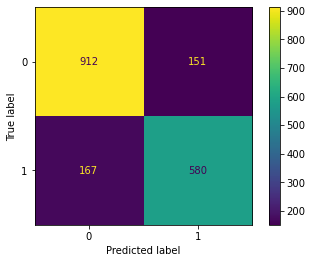

In [33]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [34]:
model_1 = DecisionTreeClassifier(max_depth=10)
model_1.fit(X_train,y_train)

y_pred_1 = model_1.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print("acuuracy score :",accuracy_score(y_test, y_pred_1))
print("f1 score :",f1_score(y_test, y_pred_1))
print("Precision score :",precision_score(y_test, y_pred_1))
print("recall score :", recall_score(y_test, y_pred_1))

acuuracy score : 0.8607734806629834
f1 score : 0.8791946308724832
Precision score : 0.8963831867057673
recall score : 0.8626528692380057


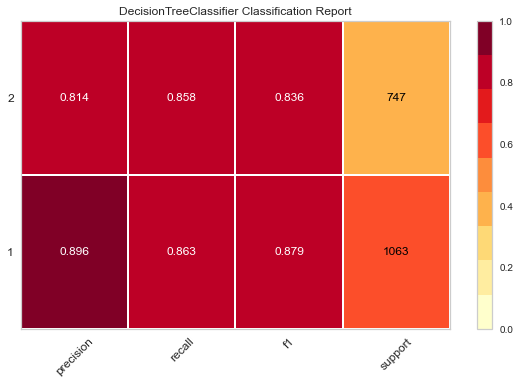

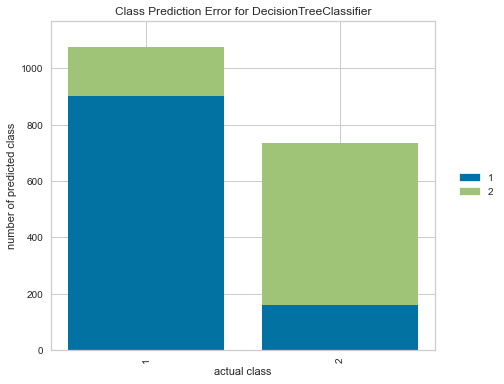

In [35]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC

visualizer = ClassificationReport(model_1, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

#classprediction report
visualizer2 = ClassPredictionError(DecisionTreeClassifier())

visualizer2.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer2.score(X_test, y_test) # Evaluate the model on the test data
g2 = visualizer2.poof() # Draw visualization



In [36]:
y_test

array([1, 2, 2, ..., 2, 2, 1])

In [37]:
B = np.where(y_test > 1, 1, 0)
print (B)


[0 1 1 ... 1 1 0]


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(B, y_pred_1)

print('roc_auc_score for DecisionTree: ', roc_auc_score(B, y_pred_1))


roc_auc_score for DecisionTree:  0.8603759660781728


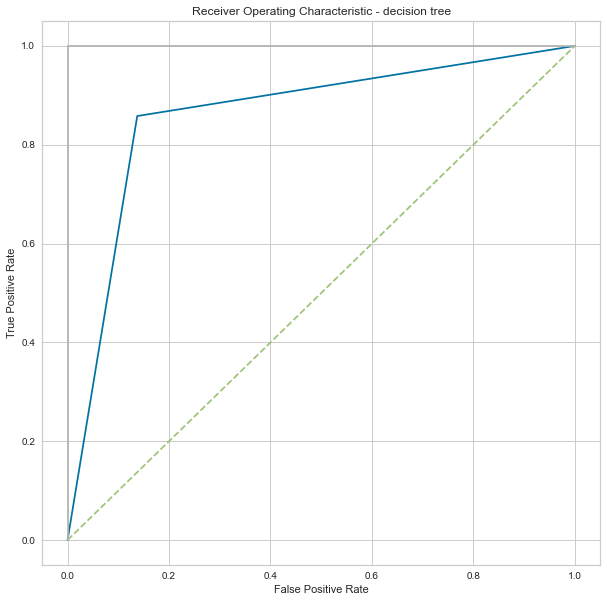

In [39]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - decision tree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

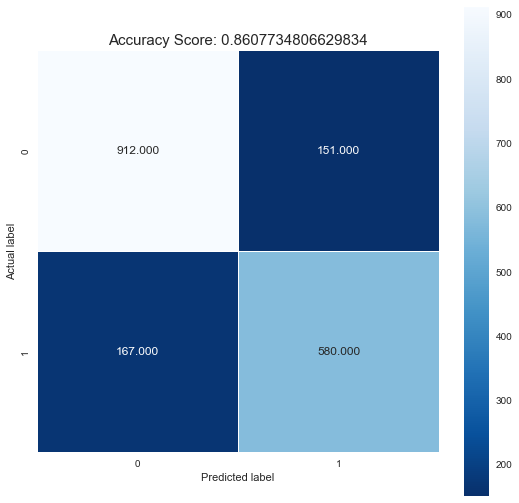

In [40]:
score = accuracy_score(y_test, y_pred_1)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [41]:
classifiers = [KNeighborsClassifier(10),
               DecisionTreeClassifier(max_depth=10),
               RandomForestClassifier(n_estimators=1000, max_depth=5),
               LogisticRegression(max_iter=100000),
               GaussianNB(),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='relu'),]

clf_names = ["Nearest Neighbors (k=10)",           
             "Decision Tree (Max Depth=10)",
             "Random Forest (Max Depth=5)",
             "Logistic Regression",
             "Gaussian Naive Bayes",
             "MLP (RelU)",]
scores_micro = dict()
scores_macro = dict()
scores_mcc = dict()
for name, clf in zip(clf_names, classifiers):
    print("fitting classifier", name)
    clf.fit(X_train, y_train)
    print("predicting labels for classifier", name)
    y_pred = clf.predict(X_test)
    scores_micro[name] = precision_recall_fscore_support(
        y_test, y_pred, average="micro")
    scores_macro[name] = precision_recall_fscore_support(
        y_test, y_pred, average="macro")
    scores_mcc[name] = matthews_corrcoef(y_test, y_pred)

scores_micro_df = pd.DataFrame(scores_micro, index=[
                               'precision (micro)', 'recall (micro)', 'fscore (micro)', 'support'])
scores_micro_df = scores_micro_df[0:3]  # drop support
scores_macro_df = pd.DataFrame(scores_macro, index=[
                               'precision (macro)', 'recall (macro)', 'fscore (macro)', 'support'])
scores_macro_df = scores_macro_df[0:3]
scores_df = scores_macro_df.append(scores_micro_df).append(
    pd.Series(scores_mcc, name='MCC'))

fitting classifier Nearest Neighbors (k=10)
predicting labels for classifier Nearest Neighbors (k=10)
fitting classifier Decision Tree (Max Depth=10)
predicting labels for classifier Decision Tree (Max Depth=10)
fitting classifier Random Forest (Max Depth=5)
predicting labels for classifier Random Forest (Max Depth=5)
fitting classifier Logistic Regression
predicting labels for classifier Logistic Regression
fitting classifier Gaussian Naive Bayes
predicting labels for classifier Gaussian Naive Bayes
fitting classifier MLP (RelU)
predicting labels for classifier MLP (RelU)


/var/folders/jz/rvrrcmrs7xg91nsn45d4tykc0000gn/T/ipykernel_1697/1253255853.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_macro_df.append(scores_micro_df).append(
/var/folders/jz/rvrrcmrs7xg91nsn45d4tykc0000gn/T/ipykernel_1697/1253255853.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_macro_df.append(scores_micro_df).append(


In [42]:
scores_df

,Nearest Neighbors (k=10),Decision Tree (Max Depth=10),Random Forest (Max Depth=5),Logistic Regression,Gaussian Naive Bayes,MLP (RelU)
precision (macro),0.797000,0.854879,0.789716,0.819330,0.674860,0.806935
recall (macro),0.774881,0.859707,0.783039,0.817194,0.662846,0.804060
fscore (macro),0.781062,0.856869,0.785713,0.818193,0.665304,0.805367
precision (micro),0.794475,0.860221,0.794475,0.824309,0.685083,0.812155
recall (micro),0.794475,0.860221,0.794475,0.824309,0.685083,0.812155
fscore (micro),0.794475,0.860221,0.794475,0.824309,0.685083,0.812155
MCC,0.571453,0.714569,0.572717,0.636521,0.337492,0.610988


/Users/sriapple/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/sriapple/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


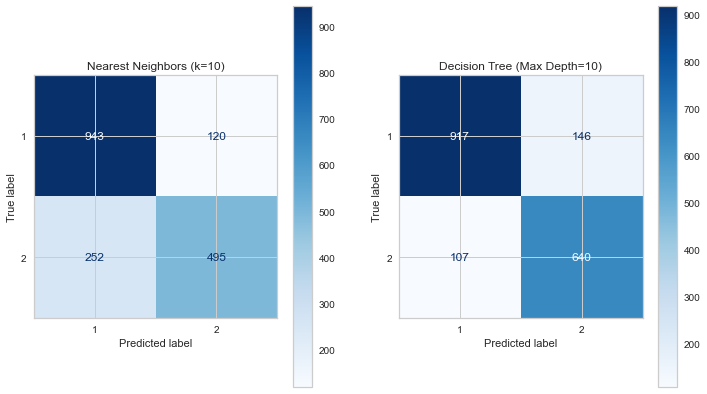

In [43]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
plot_confusion_matrix(classifiers[0], X_test, y_test, cmap=plt.cm.Blues, ax=axes[0])
plot_confusion_matrix(classifiers[1], X_test, y_test, cmap=plt.cm.Blues, ax=axes[1])
axes[0].set_title(clf_names[0])
axes[1].set_title(clf_names[1])
plt.show()

/Users/sriapple/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/sriapple/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


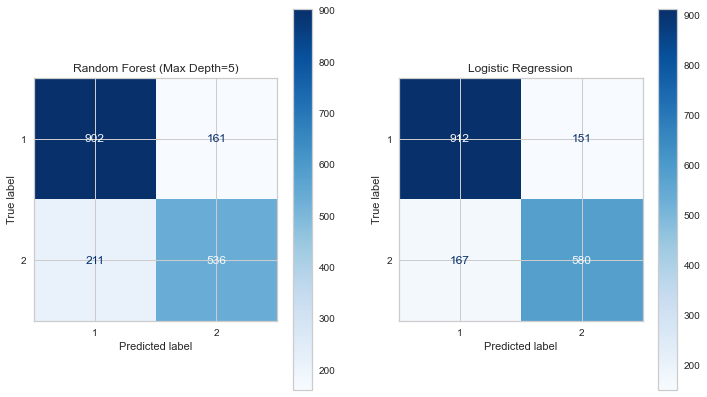

In [44]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
plot_confusion_matrix(classifiers[2], X_test, y_test, cmap=plt.cm.Blues, ax=axes[0])
plot_confusion_matrix(classifiers[3], X_test, y_test, cmap=plt.cm.Blues, ax=axes[1])
axes[0].set_title(clf_names[2])
axes[1].set_title(clf_names[3])
plt.show()

/Users/sriapple/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


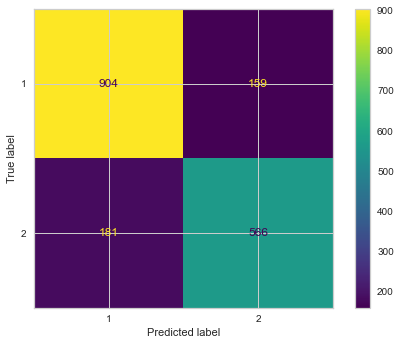

In [45]:

plot_confusion_matrix(classifiers[5], X_test, y_test)
axes[0].set_title(clf_names[5])
plt.show()

In [46]:
df2 = open_df

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574 entries, 0 to 1573
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       1574 non-null   object
 1   name         1574 non-null   object
 2   level        1574 non-null   object
 3   CreatedDate  1574 non-null   object
 4   title        1574 non-null   object
 5   description  1488 non-null   object
dtypes: object(6)
memory usage: 73.9+ KB


In [48]:
df2.isna().sum()

author          0
name            0
level           0
CreatedDate     0
title           0
description    86
dtype: int64

In [49]:
df2.description = df2.description.fillna('zero')
df2.description.isna().sum()


0

In [50]:
df2['input_data'] = df1['author']+' '+ df1['description']+' '+df1['level']+' '+df1['title']

In [51]:
df2.isna().sum()

author         0
name           0
level          0
CreatedDate    0
title          0
description    0
input_data     0
dtype: int64

In [52]:
open_text_cleaner2  = SRLUNH_CLEANER(df2)

In [56]:
C_V =CountVectorizer(max_features = 4029)

open_x =C_V.fit_transform(open_text_cleaner2).toarray()

print(np.shape(open_x))

(1574, 4029)


In [57]:
z = model1.predict(open_x)

In [58]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(z)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [59]:
df2['status_predicted'] = z

In [60]:
output = df2.drop(['description', 'input_data'],axis = 1)
output.loc[:, 'status_predicted'].replace([1,2], ['not merged', 'merged'], inplace=True)

In [61]:
output.to_csv('pr_kafka_output.csv')

In [63]:
pd.read_csv('pr_kafka_output.csv')

,Unnamed: 0,author,name,level,CreatedDate,title,status_predicted
0,0,vitojeng,Vito Jeng,CONTRIBUTOR,2021-01-04 06:53:50,KAFKA-5876: Apply UnknownStateStoreException f...,not merged
1,1,vitojeng,Vito Jeng,CONTRIBUTOR,2021-01-04 06:53:50,KAFKA-5876: Apply UnknownStateStoreException f...,not merged
2,2,dengziming,dengziming,CONTRIBUTOR,2021-01-04 05:06:01,MINOR: Make data in FetchSnapshotReq and Fetch...,not merged
3,3,dengziming,dengziming,CONTRIBUTOR,2021-01-04 05:06:01,MINOR: Make data in FetchSnapshotReq and Fetch...,not merged
4,4,dengziming,dengziming,CONTRIBUTOR,2021-01-03 09:31:29,KAFKA-10694: Implement zero copy for FetchSnap...,not merged
...,...,...,...,...,...,...,...
1569,1569,granthenke,Grant Henke,MEMBER,2015-11-19 14:49:09,KAFKA-2423: Introduce Scalastyle,not merged
1570,1570,becketqin,Jiangjie (Becket) Qin,CONTRIBUTOR,2015-09-09 17:18:44,KAFKA-2512: Add version check to broker and cl...,not merged
1571,1571,becketqin,Jiangjie (Becket) Qin,CONTRIBUTOR,2015-09-09 17:18:44,KAFKA-2512: Add version check to broker and cl...,not merged
1572,1572,pronix,Dmitry Vasilets,NONE,2015-05-10 20:07:59,add support libvirt as provider. KAFKA-2183,not merged
